# Modelo de regresión de la entalpía de atomización para una serie de moléculas

Se quiere obtener un modelo de regresión para obtener la entalpía de atomización (Enthalpy of atomization o EAT en inglés) a partir de una serie de características moleculares. Los datos se pueden descargar de Kaggle:

https://www.kaggle.com/datasets/burakhmmtgl/energy-molecule

El dataset contiene 16,242 filas y 1277 columnas. La primera columna es un índice.

Cada fila representa una molécula formada por hasta cincuenta átomos tomados del conjunto {C, H, N, O, P, S}. Las primeras 1275 columnas son los componentes de la matriz de coulomb $C$. Esta matriz se calcula para una molécula determinada considerando cada pareja de átomos $I$, $J$:

$$
    C_{IJ} =\begin{cases}
                0.5*Z_I^{2.4} & I = J \\
                \frac{Z_I Z_J}{|\bold{R}_I - \bold{R}_J|} & I \neq J
            \end{cases}
$$

donde $Z_{I}$ son los números atómicos y $\bold{R}_I$ las coordenadas atómicas. Los elementos de la diagonal principal capturan la energía de los átomos aislados y los elementos que quedan capturan la repulsión entre parejas de átomos. Los coeficientes de la fórmula para los coeficientes de la diagonal principal se han obtenido de un ajuste numérico. En este problema estamos considerando moléculas con cincuenta átomos o menos, por lo que en principio tendríamos matrices con tamaños diferentes. Para solucionar esto se añaden ceros a las matrices más pequeñas. Como la matriz es simétrica, se toma la parte triangular superior de la misma (entradas tales que $J \leq I$) y se concatenan para formar las $0.5*50*51 = 1275$ primeras columnas. La coulmna 1276 es la id de la molécula en pubchem. La última columna representa la energía de atomización calculada con el programa QuantumExpresso, con un error de aprox. 1 kcal/mol para la molécula más grande del conjunto de datos.

Debido a la gran cantidad de datos, tendremos que emplear alguna técnica de reducción de dimensionalidad. Tomaremos la técnica de principal components analysis (PCA) que se puede entender como un cambio de "coordenadas" a las "coordenadas" más significativas. Estas "coordenadas" reemplazan las columnas de nuestro dataset original y se denominan componentes principales.

Primero cargaremos los datos y realizaremos un pequeño análisis y tratamiento previo, luego pasaremos a la reducción de dimensionalidad con PCA y construiremos un modelo sencillo para tener algo con lo que comparar. Después intentaremos interpretar los componentes principales observando sus correlaciones con otras variables. Con esto intentaremos mejorar el modelo que hemos creado antes.

Referencias: 

1. Dataset: https://www.kaggle.com/datasets/burakhmmtgl/energy-molecule

2. Artículo asociado: https://arxiv.org/abs/1609.07124

3. Solución que me ha servido de mucha ayuda (De aquí he sacado unas representaciones y lo de PCA): https://www.kaggle.com/code/bashir4909/path-to-0-9955-filled-with-beauty

## Carga de los datos y análisis previo



In [1]:
# Bibiliotecas estandar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Bibliotecas de machine learning
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import  train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("../Datos/roboBohr.csv")
df.shape

(16242, 1278)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1278 entries, Unnamed: 0 to Eat
dtypes: float64(1276), int64(2)
memory usage: 158.4 MB


In [54]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


In [4]:
df.describe() # Podemos ver que hay muchas columnas y que las últimas tienen muchos zeros

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
count,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,...,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000
mean,8139.041805,115.715266,22.445723,20.474191,18.529573,17.169350,15.816888,15.133152,14.471534,13.960759,...,0.000134,0.000133,0.003879,0.000131,0.000129,0.002155,0.000127,0.001201,33107.484300,-11.178969
std,4698.182820,113.198503,8.659586,7.670481,6.485777,5.512560,4.179691,3.885091,3.503075,3.357136,...,0.002728,0.002705,0.043869,0.002676,0.002633,0.032755,0.002594,0.024472,23456.785147,3.659133
min,0.000000,36.858105,2.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-23.245373
25%,4068.250000,73.516695,17.969345,16.228071,15.165862,13.744092,13.653146,13.637784,12.759519,12.587359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12298.250000,-13.475805
50%,8142.500000,73.516695,20.662511,18.631287,17.690729,16.020040,15.156646,13.848274,13.659233,13.652832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27731.500000,-10.835211
75%,12207.750000,73.516695,21.132432,20.739496,18.712895,18.297501,17.639688,16.154918,15.499474,14.900585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55020.750000,-8.623903
max,16272.000000,388.023441,73.563510,66.269180,66.268891,66.268756,66.268196,66.264158,66.258487,66.258177,...,0.062225,0.061999,0.500000,0.061534,0.059760,0.500000,0.057834,0.500000,74980.000000,-0.789513


Por la propia explicación del dataset, ya sabemos que no hay valores Nan.

Si vemos las primeras entradas podemos ver lo que hemos estado mencionando. La primera columna es un indice, y las últimas tienen una gran cantidad de ceros. Despues tenemos la id de pubchem y la energía. Como el índice y la Id son cosas arbitrárias las podemos quitar.

In [5]:
molecules = df.drop(columns=["Unnamed: 0", "pubchem_id"], axis=1)
molecules.head()

,0,1,2,3,4,5,6,7,8,9,...,1266,1267,1268,1269,1270,1271,1272,1273,1274,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.537140


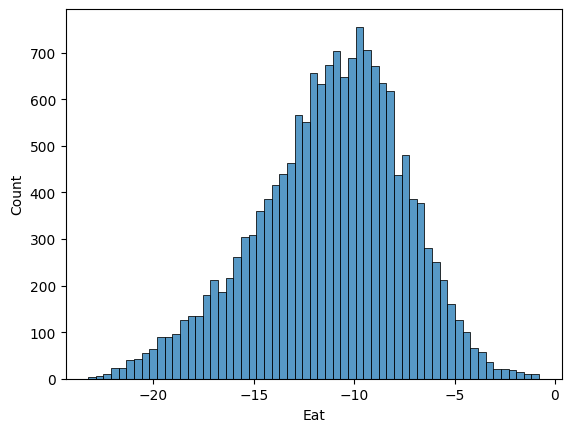

In [6]:
# Representación de las energías como histograma. Se puede apreciar una distribución aproximadamente gaussiana con asimetría en la izquierda
sns.histplot(molecules, x="Eat")
plt.show()

### Notas sobre validación

En el paper, mencionan que han tomando las esctructuras de una serie de moléculas y con ello han creado una simulación. Las estructuras de las moléculas se han sacado de PubChem, tomando las que tienen id de 1 a 75000 y filtrando para que tengan una serie de propiedades. Si quisieramos tomar las estructuras nosotros, poderíamos hacerlo mediante webscrapping. La molécula con id 25004 se puede ver en PubChem como https://pubchem.ncbi.nlm.nih.gov/compound/25004, por lo que sería relativamente directo descargar la información que necesitamos. Para realizar la simulación, habría que decidir que programa y metodo usar. Sería interesante tener una manera de automatizarlo con python. Existen métodos para acceder a Quantum Expresso con un paquete de python (https://pypi.org/project/qepy/). Si hicieramos esto, podríamos validar la información del conjunto de datos y expandirlo facilmente a otros tipos de moléculas.

## Reducción de dimensionalidad con PCA

In [7]:
# Escalamos todos los datos con standard scaler
X = StandardScaler().fit_transform(molecules.drop(columns=["Eat"]))
Y = molecules["Eat"].values

X_dataframe = pd.DataFrame(X)
Y_dataframe = pd.DataFrame(Y).rename(lambda _: "Eat", axis=1)

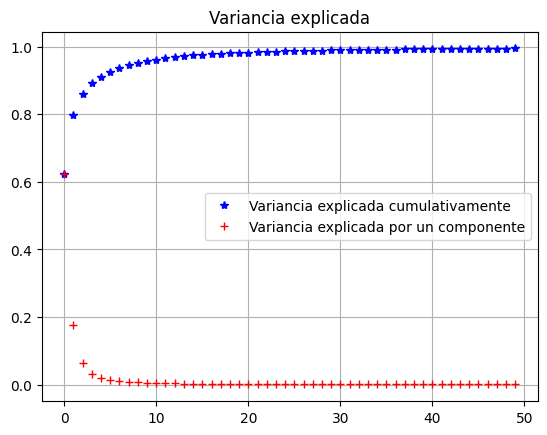

In [8]:
# Vamos a ver cuantos componentes necesitamos para explicar la variancia del dataset
N_PCA = 50 # Numero de componentes
p = PCA(n_components=N_PCA).fit(X)
ns = list(range(N_PCA))

plt.figure()
plt.title("Variancia explicada")
plt.plot(ns, [p.explained_variance_ratio_.cumsum()[n] for n in ns], 'b*', label="Variancia explicada cumulativamente")
plt.plot(ns, [p.explained_variance_ratio_[n] for n in ns], 'r+', label="Variancia explicada por un componente")
plt.legend()
plt.grid()
plt.show()

Podemos ver que uno ya explica alrededor del 60% de la variancia del dataset. Con entre 20 y 30 componentes se explica la gran mayoría de la varianza. Nosotros tomaremos los 25 primeros componentes. Esto significa que pasamos de miles de columnas a decenas. Veamos como se obtienen los componentes principales a partir de la variable p y representemos alguno de ellos.

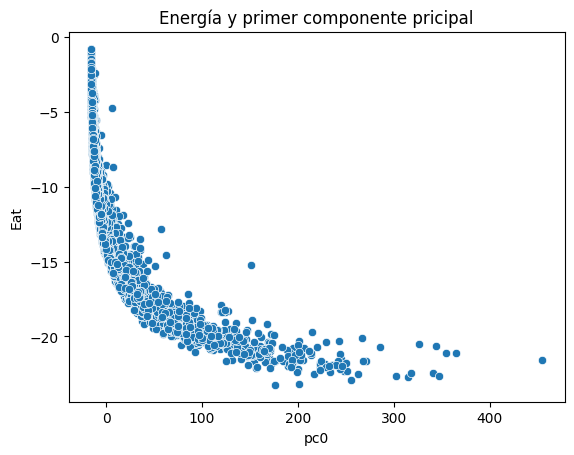

In [9]:
# Sacamos los primeros 25 componentes
X_reduced = p.transform(X)[:,:25] 
# Creamos un dataframe con los nuevos componentes. Cambiamos los nombres de las columnas para que sea más claro
X_reduced_dataframe = pd.DataFrame(X_reduced).rename(lambda i: "pc"+str(i), axis=1) 

#plt.scatter(X_reduced_dataframe["pc0"], Y_dataframe["Eat"])
plt.title("Energía y primer componente pricipal")
sns.scatterplot(pd.concat([X_reduced_dataframe, Y_dataframe], axis=1), x="pc0", y="Eat")
plt.show()

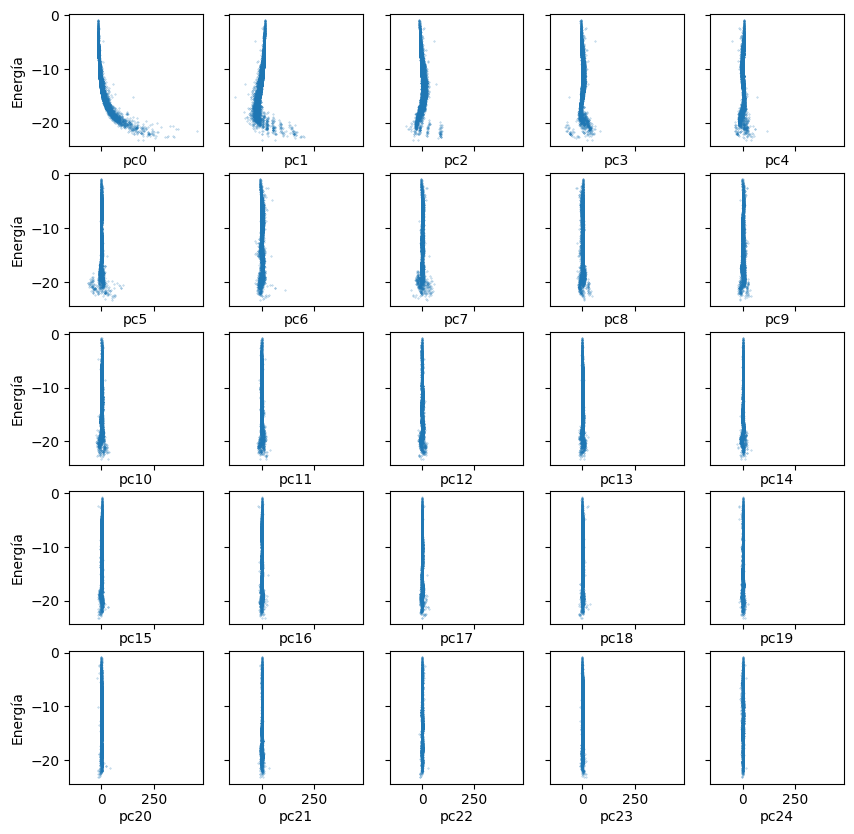

In [10]:
# Representemos la energía en función de cada uno de los componentes
fig = plt.figure(figsize=(10,10))
# Realizamos una tabla de 5*5 para poner cada una de las subfiguras
axs = fig.subplots(5, 5, sharex=True, sharey=True) # sharex y sharey = True para que todas las subfiguras compartan eje x y eje y
# Recorremos todas las subfiguras
for i, ax in enumerate(axs.flatten()):
    # Si son las del lado izquierdo, etiqueta el eje y
    if i%5 == 0:
        ax.set_ylabel("Energía")
    # Representa el componente que toque
    componente = "pc" + str(i)
    ax.scatter(X_reduced_dataframe[componente], Y_dataframe["Eat"], s=0.1, alpha=0.5)
    # Cambia la etiqueta del eje x y los parámetros de los marcadores
    ax.set_xlabel(componente, labelpad=2)

Podemos ver que existen dependencias interesantes en los primeros componentes, pero que según avanzamos los componentes no se relacionan con la energía. 

## Modelo inicial

Utilizaremos el ExtraTreesRegressor

In [11]:
# Escalamos todos los datos con standard scaler
X = StandardScaler().fit_transform(molecules.drop(columns=["Eat"]))
Y = molecules["Eat"].values

N_PCA = 50 # Numero de componentes
p = PCA(n_components=N_PCA).fit(X)

In [12]:
X_reduced =  p.transform(X)[:,:25] # 25 primeros
Y = molecules["Eat"].values

In [13]:
print(X_reduced[0].min(), X_reduced[0].max())

-42.23300756611384 97.34969356837038


In [14]:
# Selecciono el conjunto de entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2)

#Entrenamiento del modelo, a través de árboles de regresión, con un total de 200 estimadores.
regressor = ExtraTreesRegressor(n_estimators = 200)
regressor.fit(X_train, y_train)

#Predicción y evaluación
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

print('ExtraTreesRegressor... evaluando resultado:')
print("Train MAE:  ", sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
print("Train RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
print("Test MAE:   ", sklearn.metrics.mean_absolute_error(y_test, y_test_pred))
print("Test RMSE:  ", np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_test_pred)))
print()
print("R cuadrado:      ", sklearn.metrics.r2_score(y_train, y_train_pred))
print("R cuadrado test: ", sklearn.metrics.r2_score(y_test, y_test_pred))

ExtraTreesRegressor... evaluando resultado:
Train MAE:   2.540761249510299e-10
Train RMSE:  7.596705918252245e-09
Test MAE:    0.11171969313509413
Test RMSE:   0.18560459911704547

R cuadrado:       1.0
R cuadrado test:  0.9974975055080192


In [80]:
print(np.std(Y))

3.6590201382654026


Algunos valores de $R^2$: 0.9959520487030427, 0.9977346241164204, 0.9969666719896788, 0.99738119609628

Para 200 estimadores y un 20% de los datos para test, el modelo obtiene un $R^2$ muy alto, siendo 0.9975 - 0.9955. Si subimos la candidad de datos para test, $R^2$ no se ve afectado mucho, pasando a 0.992 con un 90% de los datos para test. Sucede algo similar si reducimos la cantidad de estimadores. A parte de eso, los errores son pequeños en comparación con la desviación estandard de la variable de predicción (La energía tiene una STD de 3.66). En general este modelo es bueno.

Ranking importancia de las características

pca0 (0.389307)
pca1 (0.274277)
pca2 (0.091246)
pca3 (0.030963)
pca4 (0.029822)
pca5 (0.023611)
pca6 (0.020921)
pca7 (0.016346)
pca8 (0.015809)
pca9 (0.015717)
pca10 (0.015579)
pca11 (0.010288)
pca12 (0.009506)
pca13 (0.009093)
pca14 (0.008296)
pca15 (0.007216)
pca16 (0.006088)
pca17 (0.005545)
pca18 (0.004393)
pca19 (0.004103)
pca20 (0.003447)
pca21 (0.003036)
pca22 (0.002088)
pca23 (0.001798)
pca24 (0.001505)


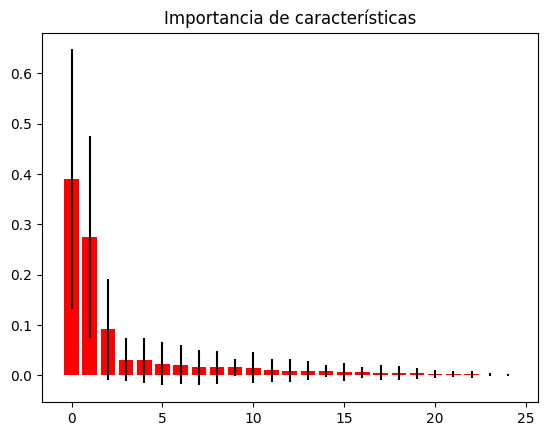

In [15]:
print('Ranking importancia de las características\n')
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importance_list = []
for f in range(X_reduced.shape[1]):
    importance_list.append(f)
    print("pca%d (%f)" % (f, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Importancia de características")
plt.bar(importance_list, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.show()

Podemos ver que las características más importantes son los tres primeros componentes principales. Ahora bien, estos componentes principales no son nuestras variables originales. Tenemos que ver como se relacionan los componentes principales con los datos originales.

Tambien podemos ver que existe mucha desviación típica en la importancia. Esto significa que existen grupos dentro de los datos que se comportan de formas diferentes: hay grupos para los cuales diferentes componentes tienen diferentes importancias. 

Vamos a ver como cambia el resultado del modelo si variamos los dos componentes principales. Tomaremos el resto de componentes como cero, que está muy cenca de cero.

In [82]:
for t in X_reduced.T:
    print(t.min(), t.max(), t.std(), t.mean())

-15.592673985116685 454.56249872144474 28.15126757693682 -6.7195766662203785e-16
-125.5791379609587 200.1988562120086 14.93158936569885 1.399911805462579e-16
-75.50267678639133 96.90785109297718 9.037678636554789 3.9197530552952206e-16
-81.92658093467091 85.63075314032997 6.396005128663532 4.0597442358414787e-16
-52.326969374944596 113.61387638846769 4.825897548323273 8.399470832775473e-17
-64.98217186934038 104.44116669269852 4.35110160132184 2.519841249832642e-16
-31.741834712421827 109.61632834136601 3.7883034954332517 -8.049492881409828e-17
-51.070569066221516 57.27939584522004 3.273914566529896 -1.095430987774468e-15
-30.111699933820212 44.692232661371655 2.8568928761608885 9.099426735506762e-17
-23.17940605544588 37.362190693479555 2.660992476795974 7.419532568951668e-16
-25.000453004936027 35.083102587466804 2.3964510395369074 4.514715572616817e-16
-20.609090128561782 38.7636470443401 2.2375161755062436 -5.63464501698688e-16
-19.619579609293485 21.09142427789086 2.04195404959367

In [83]:
from itertools import product

In [84]:
num_puntos = 100
ejes = [np.linspace(t.min(), t.max(), num=num_puntos) for t in X_reduced.T[0:2]]
X_inv = np.array(list(product(*ejes)))
X_inv.shape

(10000, 2)

In [85]:
X_inventado = np.zeros((X_inv.shape[0], 25)) # 25 es el número de columnas

for i in range(0, X_inv.shape[0]):
    for j in range(0, 25):
        try:
            X_inventado[i][j] = X_inv[i][j]
        except IndexError:
            pass

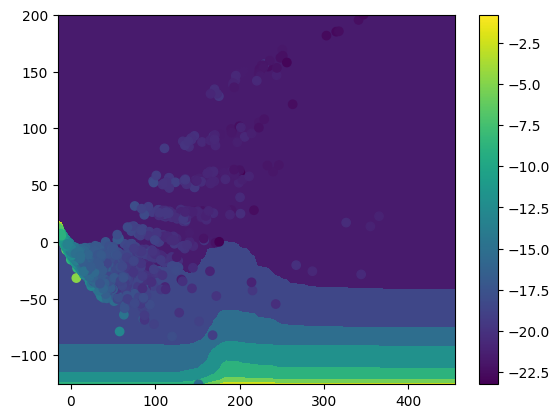

In [91]:
Y_inventado = regressor.predict(X_inventado)

X_mesh, Y_mesh = np.meshgrid(*ejes)

plt.contourf(X_mesh, Y_mesh, np.reshape(Y_inventado, (num_puntos, num_puntos)))
plt.scatter(X_reduced.T[0], X_reduced.T[1], c=Y)
plt.colorbar()
plt.show()

## Interpretación de los componentes principales

Vamos a ver las correlaciones de los componentes principales con otras columnas.

In [16]:
# Volvemos a hacer lo mismo, esta vez también creamos varios dataframes para realizar correlaciones
# Escalamos todos los datos con standard scaler
X = StandardScaler().fit_transform(molecules.drop(columns=["Eat"]))
Y = molecules["Eat"].values

X_dataframe = pd.DataFrame(X)
Y_dataframe = pd.DataFrame(Y).rename(lambda _: "Eat", axis=1)

N_PCA = 50 # Numero de componentes
p = PCA(n_components=N_PCA).fit(X)

X_reduced =  p.transform(X)[:,:25] # 25 primeros
X_reduced_dataframe = pd.DataFrame(X_reduced).rename(lambda i: "pc"+str(i), axis=1)

In [17]:
df2 = pd.concat([X_dataframe, X_reduced_dataframe, Y_dataframe], axis=1)
corr = df2.corr() # tarda un minuto con todos los datos

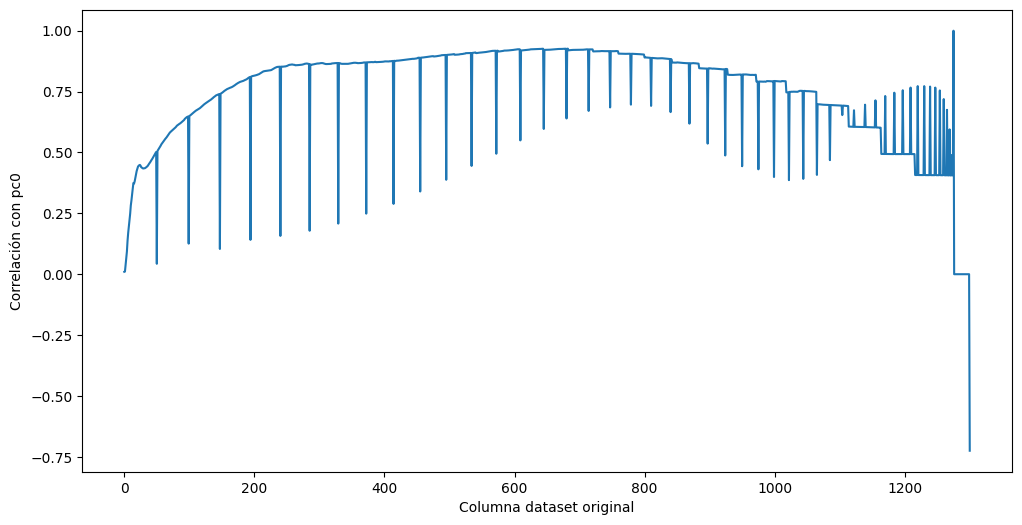

In [18]:
plt.figure(figsize=(12, 6))

comp = "pc0"

corr[comp].plot()

plt.xlabel("Columna dataset original")
plt.ylabel(f"Correlación con {comp}")

plt.show()

Viendo esta representación de cada columna del dataset original con el primer componente, podemos observar unas cuantas cosas:

1. Existen unos picos extremos muy pronunciados. Si los contamos parece haber unos 50 y según avanza la gráfica se van acercando más. ¿Podrían ser los componentes de la diagonal principal?

2. Existe un comportamiento raro al final. Por como hemos concatenado los dataframes, el último punto se corresponde a la correlación con la entalpía de atomización. También existe un pico con correlación 1 que es la correlacion del componente con sigo mismo. Las correlaciones entre esas dos son las correlaciones entre componentes principales. 

3. Si ignoramos los picos, existe una buena correlación entre el primer componente y las columnas 200 a 800. Según avanzamos en los componentes las correlaciones se vuelven más pequeñas. 

Cambiando el componente principal que estamos mirando, podemos ver que los picos se repiten en todos, y que el primero tiene las correlaciones más grandes. 

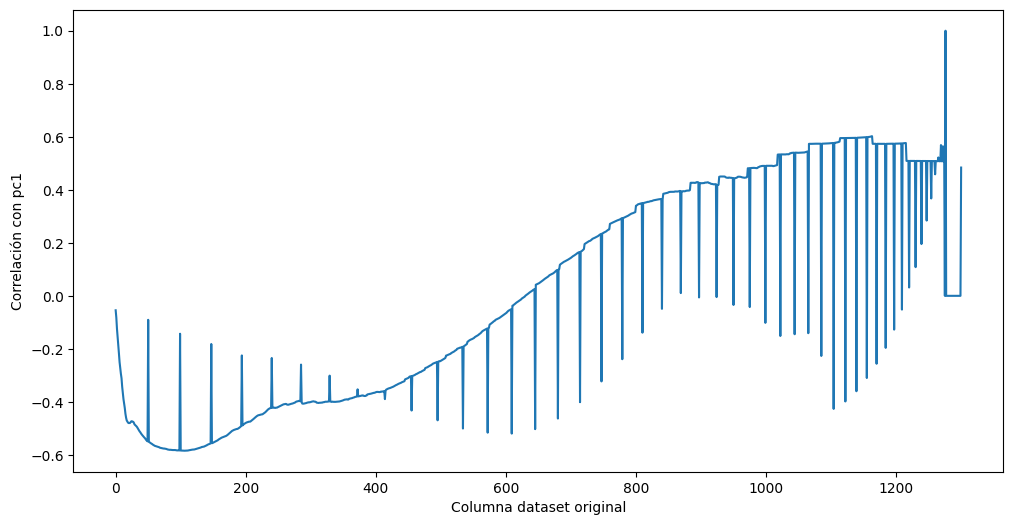

In [27]:
# Misma representación para otro componente 
plt.figure(figsize=(12, 6))

comp = "pc1"

corr[comp].plot()

plt.xlabel("Columna dataset original")
plt.ylabel(f"Correlación con {comp}")

plt.show()

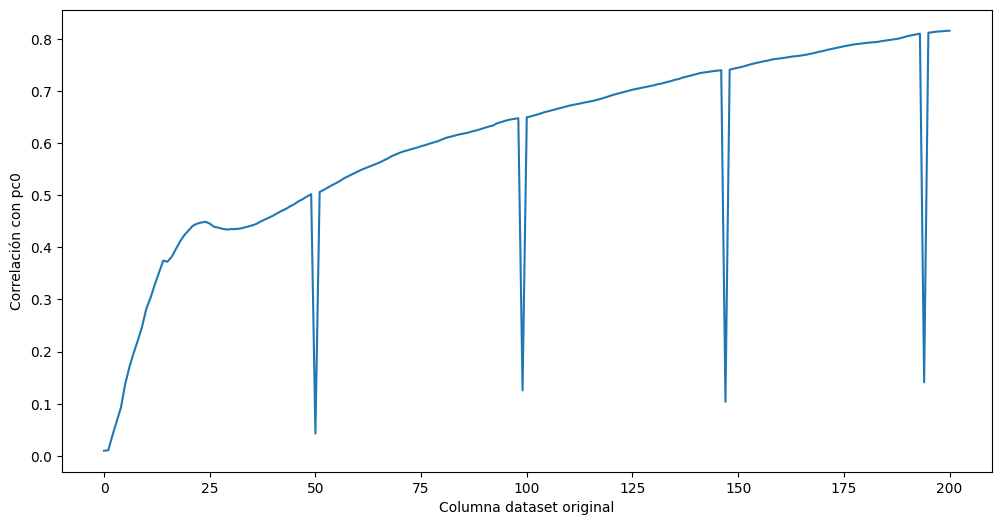

In [28]:
# Para ver los pícos más de cerca. Parecen estár en 50, 99, 
plt.figure(figsize=(12, 6))

comp = "pc0"

plt.plot(corr[comp].loc[0:200]) # Representar solo las 200 primeras. Así lo podemos ver con más detalle

plt.xlabel("Columna dataset original")
plt.ylabel(f"Correlación con {comp}")

plt.show()

De cara a la localicación de los picos, podemos pensar que suceden en las columnas que representan la diagonal principal.

### Obtención de los componentes de la diagonal principal

La diagonal principal se corresponde a las columnas 0, 50, 99 ... donde empezamos por el cero y le sumamos 50, 49, 48... Habrá 50 componentes en total. Podemos obtenerlas de la siguiente manera:

In [29]:
indices = [0]
for i in range(50, 1, -1):
    #print(i, indices[-1], i + indices[-1])
    indices.append(i + indices[-1])
print(indices)
# Convierte todo a strings
indices = [str(i) for i in indices]

[0, 50, 99, 147, 194, 240, 285, 329, 372, 414, 455, 495, 534, 572, 609, 645, 680, 714, 747, 779, 810, 840, 869, 897, 924, 950, 975, 999, 1022, 1044, 1065, 1085, 1104, 1122, 1139, 1155, 1170, 1184, 1197, 1209, 1220, 1230, 1239, 1247, 1254, 1260, 1265, 1269, 1272, 1274]


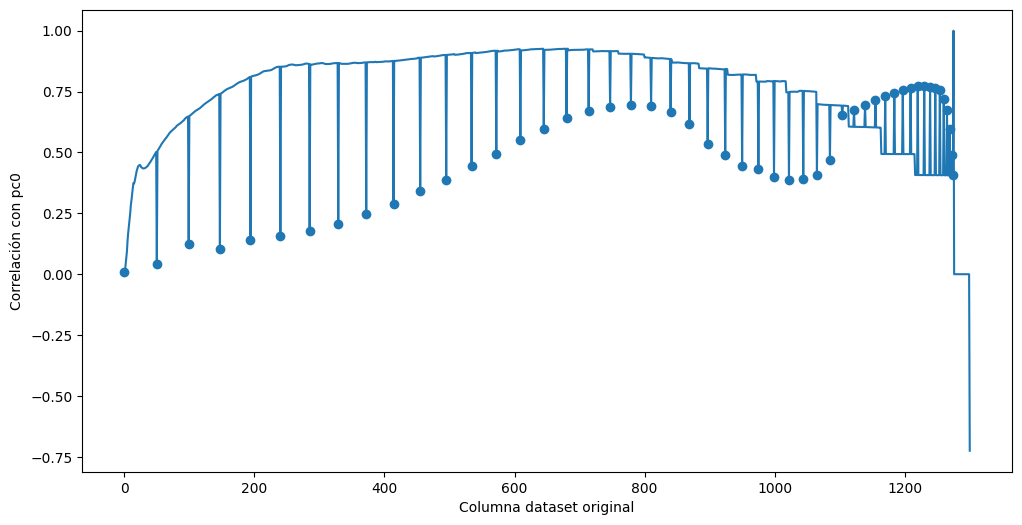

In [30]:
# Representamos las correlaciones de nuevo, marcando aquellas que se corresponden con la diagonal principal
plt.figure(figsize=(12, 6))
comp = "pc0"
corr[comp].plot() # Representar todas las correlaciones
 # Scatter de las correlaciones correspondientes a los indices de la diagonal principal
plt.scatter([int(i) for i in indices], corr[comp][[int(i) for i in indices]].values)

plt.xlabel("Columna dataset original")
plt.ylabel(f"Correlación con {comp}")

plt.show()

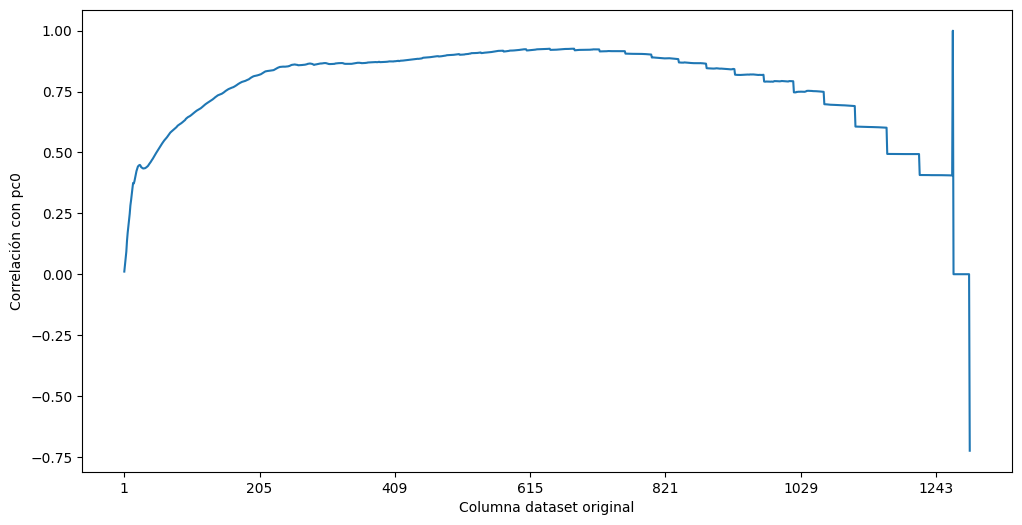

In [31]:
# Otra vez lo mismo pero ahora quitamos los picos en vez de marcarlos
plt.figure(figsize=(12, 6))
comp = "pc0"
corr[comp].drop([int(i) for i in indices]).plot()

plt.xlabel("Columna dataset original")
plt.ylabel(f"Correlación con {comp}")

plt.show()

Parecen coincidir de forma perfecta, lo que significa que los picos se producen en la diagonal principal. La diagonal principal es como un dato atípico en el sentido de que no se comporta como los componentes que tienen "a su lado". Sería interesante hacer algo con esta diagonal principal, como quitarla o cambiar su definición por otra cosa. 

### Mapa de calor de las correlaciones

Cada pixel será la corrleación de un componente escogido con una columna del dataset. Tomaremos las correlaciones y las transformaremos de vuelta a una matriz de 50 por 50. Basicamente es otra forma de ver lo que estábamos viendo arriba, solo que en vez de una línea tendremos un mapa de calor.

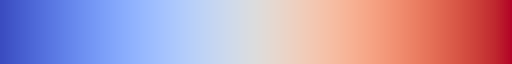

In [32]:
# Escogemos un mapa de color para las imágenes
import matplotlib as mpl
# mpl.colormaps() Para ver todos los mapas de color
mycmap = mpl.colormaps["coolwarm"] 
mycmap

-0.09051149059358067 -0.09051149059358067


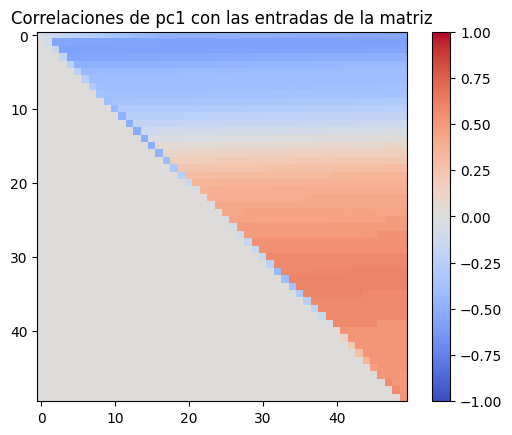

In [33]:
componente = "pc1" # "Eat" tambien es una opción

# Toma las correlaciones de las entradas de la matriz
entradas = corr[componente].loc[0:1274].values
# transforma las entradas a una matriz
coulomb_corr = np.zeros((50, 50))

entradas_iter = iter(entradas) # Usaremos un iterable de las entradas para iterar implicitamente

for row in range(0, 50):
    for column in range(row, 50):
        coulomb_corr[row][column] = entradas_iter.__next__()
print(coulomb_corr[1][1], entradas[50]) # Comprueba que funciona, ambas cosas deben ser iguales

# Representamos la matriz

plt.title(f"Correlaciones de {componente} con las entradas de la matriz")
plt.imshow(coulomb_corr, cmap=mycmap, vmin=-1, vmax=1) # Para poder comparar las imágenes mejor, ajustamos los rangos de la imagen
plt.colorbar()
plt.show()

In [34]:
# Hagamos una función que nos de la matriz 
def get_coulomb_corr_matrix(comp) -> np.array:
    # Toma las correlaciones de las entradas de la matriz
    entradas = corr[comp].loc[0:1274].values
    # Crea la matriz vacía a la que asignaremos los valores apropiados
    coulomb_corr = np.zeros((50, 50))

    entradas_iter = iter(entradas) # Usaremos un iterable de las entradas para iterar implicitamente

    for row in range(0, 50):
        for column in range(row, 50):
            coulomb_corr[row][column] = entradas_iter.__next__()
    return coulomb_corr

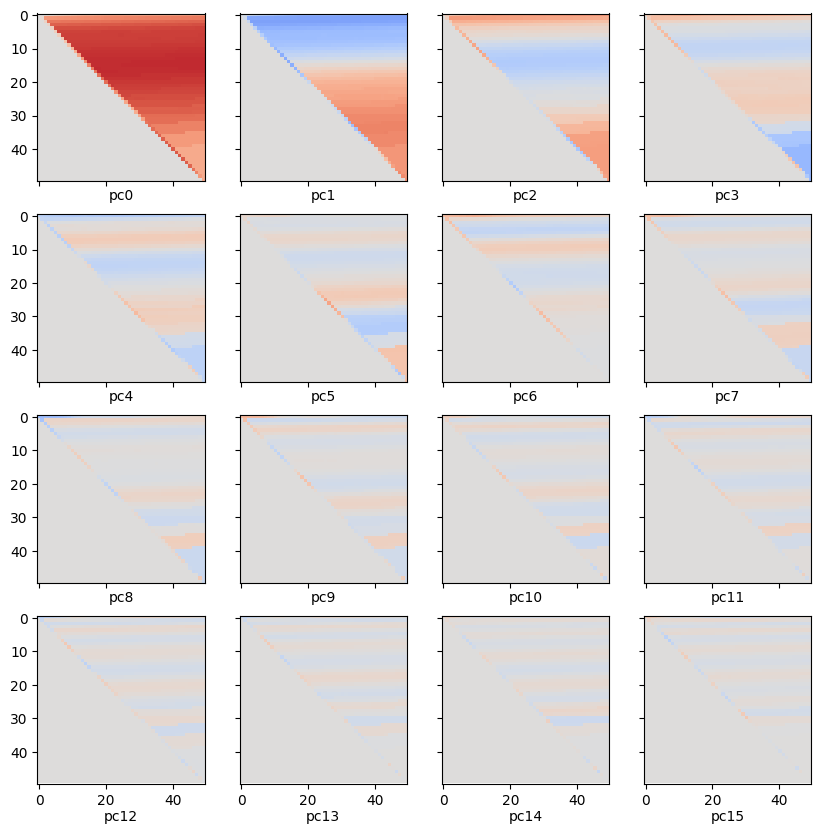

In [35]:
# Representemos todas las matrices juntas
fig = plt.figure(figsize=(10,10))
# Realizamos una tabla de 4*4, ya que los componentes más altos casi no se ven
axs = fig.subplots(4, 4, sharex=True, sharey=True) # sharex y sharey = True para que todas las subfiguras compartan eje x y eje y
# Recorremos todas las subfiguras
for i, ax in enumerate(axs.flatten()):
    # Representa el componente que toque
    componente = "pc" + str(i)
    ax.imshow(get_coulomb_corr_matrix(componente), cmap=mycmap, vmin=-1, vmax=1)
    # Cambia la etiqueta del eje x y los parámetros de los marcadores
    ax.set_xlabel(componente, labelpad=2)

Viendo estas correlaciones todas juntas de esta forma, parece que las correlaciones tienen una característica ondulatoria según avanza el componente. No se si esto se debe a algún detalle del algoritmo. Tambien podemos ver más claramente que parece que el algoritmo requiere de más dimensiones para capturar el hecho de que hay muchos ceros en el final de algunas de las entradas. Esto se puede ver porque el primer componente está menos correlacionado con las columnas del final, por lo que necesitamos más componentes para capturar esos detalles. Retomaremos esta idea más adelante.

## Segundo modelo

Vamos a ver que efecto tiene eliminar la diagonal principal de nuestros datos.

In [36]:
# Escalamos todos los datos con standard scaler
temp = molecules.drop(columns=indices, axis=1).drop(columns=["Eat"])
X = StandardScaler().fit_transform(temp)
Y = molecules["Eat"].values

N_PCA = 50 # Numero de componentes
p = PCA(n_components=N_PCA).fit(X)

In [37]:
X_reduced =  p.transform(X)[:,:25] # 25 primeros
Y = molecules["Eat"].values

In [38]:
# Selecciono el conjunto de entrenamiento y test.
X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2)

#Entrenamiento del modelo, a través de árboles de regresión, con un total de 200 estimadores.
regressor = ExtraTreesRegressor(n_estimators = 200)
regressor.fit(X_train, y_train)

#Predicción y evaluación
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

print('ExtraTreesRegressor... evaluando resultado:')
print("Train MAE:  ", sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
print("Train RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
print("Test MAE:   ", sklearn.metrics.mean_absolute_error(y_test, y_test_pred))
print("Test RMSE:  ", np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_test_pred)))
print()
print("R cuadrado:      ", sklearn.metrics.r2_score(y_train, y_train_pred))
print("R cuadrado test: ", sklearn.metrics.r2_score(y_test, y_test_pred))

ExtraTreesRegressor... evaluando resultado:
Train MAE:   1.6052581642661623e-10
Train RMSE:  5.143820827167685e-09
Test MAE:    0.13344923162687036
Test RMSE:   0.20695152961202717

R cuadrado:       1.0
R cuadrado test:  0.9968451181151834


Algunos valores de $R^2$: 0.9959916191569698, 0.9968264230977357, 0.9965756493015697, 0.9965855176944135

Si comparamos con el modelo previo, podemos ver que este modelo es ligeramente peor en lo que a $R^2$ respecta. Esto significa que a pesar de ser atípicos en ese sentido, la diagonal principal es útil para nuestro modelo.

## Números atómicos

Teniendo en cuenta lo que hemos visto, sospechamos que la gran cantidad de ceros en algunas de las entradas puede estar afectando negativamente a la capacidad de predicción del algoritmo. Además, hemos podido comprobar que reducir significativamente el número de estimadores y la cantidad de los datos de entrenamiento no produce una bajada muy intensa de la calidad del modelo. Por ello sería razonable dividir los datos según el número de átomos de las moléculas para intentar reducir el número de ceros en cada una de las filas.

Para poder realizar esta separación debemos considerar la matriz de donde vienen los datos. Si nos centramos en la diagonal principal, podemos invertir la fórmula: $C_{II} = 0.5*Z_I^{2.4} \Rightarrow Z_I = (2C_{II})^(5/12)$ obteniendo de esta manera los números atómicos de los átomos constituyentes.

In [39]:
diag_principal = molecules[indices] # Seleccionamos la diagonal principal
# Ahora obtenemos los números atómicos con la fórmula invertida
atomic_nums = diag_principal.pipe(lambda t: (2*t)**(5/12))
atomic_nums.head()

,0,50,99,147,194,240,285,329,372,414,...,1220,1230,1239,1247,1254,1260,1265,1269,1272,1274
0,8.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,8.0,8.0,8.0,8.0,8.0,7.0,6.0,6.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,8.0,8.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,8.0,6.0,6.0,6.0,6.0,6.0,6.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Parece que ha funcionado, por lo menos para las primeras entradas. Estoy bastante sorprendido con el poco error que esta operación a incurrido. Esperaba que como estamos usando floats hubiese inexactitud. Es posible que al mostrarlo se esté haciendo un poco de redondeo. 

Si vamos a la fila 0 podemos ver que el primer átomo es oxígeno, el segundo carbono, luego carbono etc. De aquí podríamos ver que tipo de átomo se relaciona más con la energía, que átomo abunda más etc

Para una molecula, podemos contar cuantos átomos hay de cada uno de la siguiente forma:

In [40]:
indice_molecula = 0
print(atomic_nums.loc[indice_molecula].value_counts()) 

1.0    32
6.0    15
0.0     2
8.0     1
Name: 0, dtype: int64


La molécula 0 tiene 32 hidrógenos, 15 carbonos y 1 oxigeno. Ya sabemos que la molecula 0 tiene id 25004 y se puede ver en PubChem como https://pubchem.ncbi.nlm.nih.gov/compound/25004, con lo que se comprueba a la perfección.

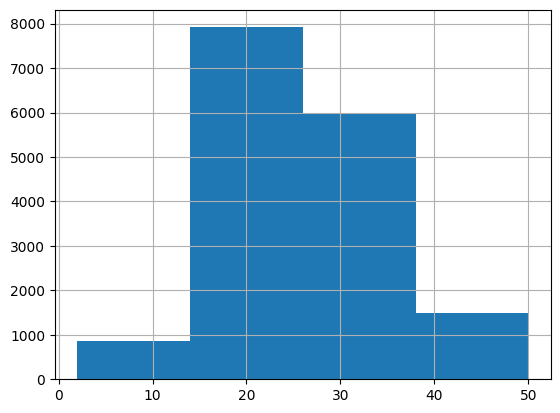

In [41]:
# Seleccionamos aquellas entradas que no sean cero y contamos valores no NaN. Luego lo representamos en un histograma
atomic_nums[atomic_nums != 0].count(axis=1).hist(bins=4)
plt.show()

Claramente no podemos seleccionar 50 cubos, ya que para algunos tendríamos cubos con decenas de particulas. Nuestro modelo parece ser flexible, pero no tanto. Podemos tomar 5 o 4 cubos.

In [42]:
# Podemos añadirlo como una columna
molecules["número de átomos"] = atomic_nums[atomic_nums != 0].count(axis=1)

Vamos a hacerlo para que podamos escoger el número de cubos.

In [43]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
cubos = 2
molecules["número de átomos"] = pd.cut(atomic_nums[atomic_nums != 0].count(axis=1), bins=cubos) # , labels=["t1", "t2", "t3", "t4"]

Grupo 1 va de 1.952 a 26.0 atomos. (x = 351, shape: (9550, 1277))


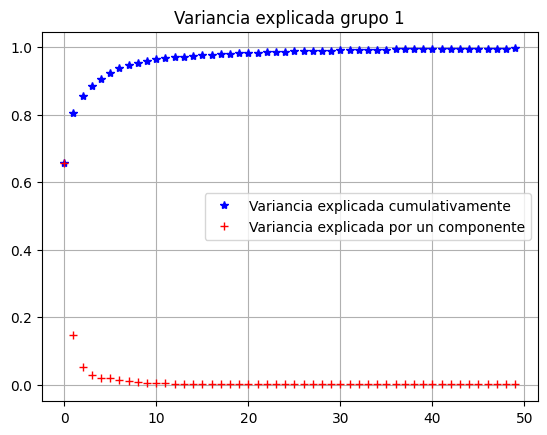

Grupo 2 va de 26.0 a 50.0 atomos. (x = 1275, shape: (6692, 1277))


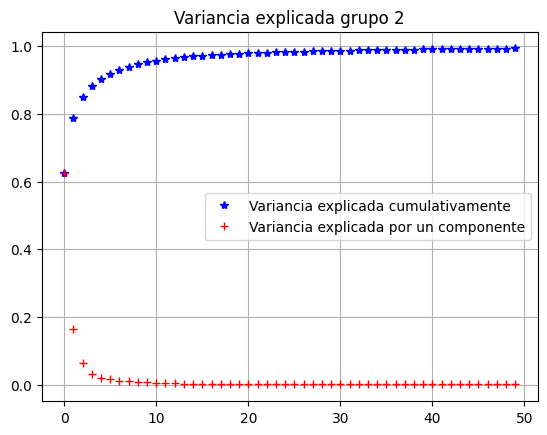

In [44]:
groups = molecules.groupby("número de átomos")

for i, g in enumerate(groups, start=1):
    intervalo, datos_grupo = g
    x = int(intervalo.right*(intervalo.right + 1)*0.5) # Indice desde el que hacer drop
    print(f"Grupo {i} va de {intervalo.left} a {intervalo.right} atomos. ({x = }, shape: {datos_grupo.shape})")
    datos_droped = datos_grupo.drop("número de átomos", axis=1).drop([str(i) for i in range(x, 1274+1)], axis=1)

    X = StandardScaler().fit_transform(datos_droped)
    Y = datos_droped["Eat"].values
    
    # Vamos a ver cuantos componentes necesitamos para explicar la variancia del dataset

    N_PCA = 50 # Numero de componentes
    p = PCA(n_components=N_PCA).fit(X)
    ns = list(range(N_PCA))

    plt.figure()
    plt.title(F"Variancia explicada grupo {i}")
    plt.plot(ns, [p.explained_variance_ratio_.cumsum()[n] for n in ns], 'b*', label="Variancia explicada cumulativamente")
    plt.plot(ns, [p.explained_variance_ratio_[n] for n in ns], 'r+', label="Variancia explicada por un componente")
    plt.legend()
    plt.grid()
    plt.show()

In [45]:
groups = molecules.groupby("número de átomos")

for i, g in enumerate(groups, start=1):
    intervalo, datos_grupo = g
    x = int(intervalo.right*(intervalo.right + 1)*0.5) # Indice desde el que hacer drop
    print(f"Grupo {i} va de {intervalo.left} a {intervalo.right} atomos. ({x = }, shape: {datos_grupo.shape})")
    datos_droped = datos_grupo.drop("número de átomos", axis=1).drop([str(i) for i in range(x, 1274+1)], axis=1)

    X = StandardScaler().fit_transform(datos_droped)
    p = PCA().fit(X)

    X_reduced =  p.transform(X)[:,:25] # 25 primeros
    Y = datos_droped["Eat"].values

    # Selecciono el conjunto de entrenamiento y test.
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, test_size=0.2)

    #Entrenamiento del modelo, a través de árboles de regresión
    regressor = ExtraTreesRegressor(n_estimators = 50)
    regressor.fit(X_train, y_train)

    #Predicción y evaluación
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)

    print("Estadísticas:")
    print("    Train MAE:  ", sklearn.metrics.mean_absolute_error(y_train, y_train_pred))
    print("    Train RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
    print("    Test MAE:   ", sklearn.metrics.mean_absolute_error(y_test, y_test_pred))
    print("    Test RMSE:  ", np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_test_pred)))
    print()
    print("    R cuadrado:      ", sklearn.metrics.r2_score(y_train, y_train_pred))
    print("    R cuadrado test: ", sklearn.metrics.r2_score(y_test, y_test_pred))
    print()

Grupo 1 va de 1.952 a 26.0 atomos. (x = 351, shape: (9550, 1277))
Estadísticas:
    Train MAE:   1.8791100162225776e-10
    Train RMSE:  7.225986322428444e-09
    Test MAE:    0.10145132418848153
    Test RMSE:   0.19767513376772855

    R cuadrado:       1.0
    R cuadrado test:  0.990619047590472

Grupo 2 va de 26.0 a 50.0 atomos. (x = 1275, shape: (6692, 1277))
Estadísticas:
    Train MAE:   1.5319495544464826e-10
    Train RMSE:  5.298840733639512e-09
    Test MAE:    0.13340966133211252
    Test RMSE:   0.2029265973835954

    R cuadrado:       1.0
    R cuadrado test:  0.9937514475605969



Claramente podemos ver que lo que hemos intentado no ha funcionado muy bien. Tenemos sobreajuste, ya que el $R^2$ es uno para el entrenamiento pero más bajo para el test. Los resultados son mejores para los cubos con más datos.

Para cubos con más datos, el error es más pequeño que el primer modelo, a pesar de que el R^2 sea menor. 